# NGC4321

In [1]:
import numpy as np
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.nddata import Cutout2D
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
import pylab as plt
from astropy.utils.data import get_pkg_data_filename
from IPython.display import Image
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import pandas as pd
from astroquery.ned import Ned
import matplotlib.patches as mpatches
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon
import shapely

In [2]:
import matplotlib.pyplot as plt
plt.style.use('classic')
import matplotlib
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['PT Serif']})
rc('text', usetex=True)
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

In [3]:
Mpc = 15.9
incl=34

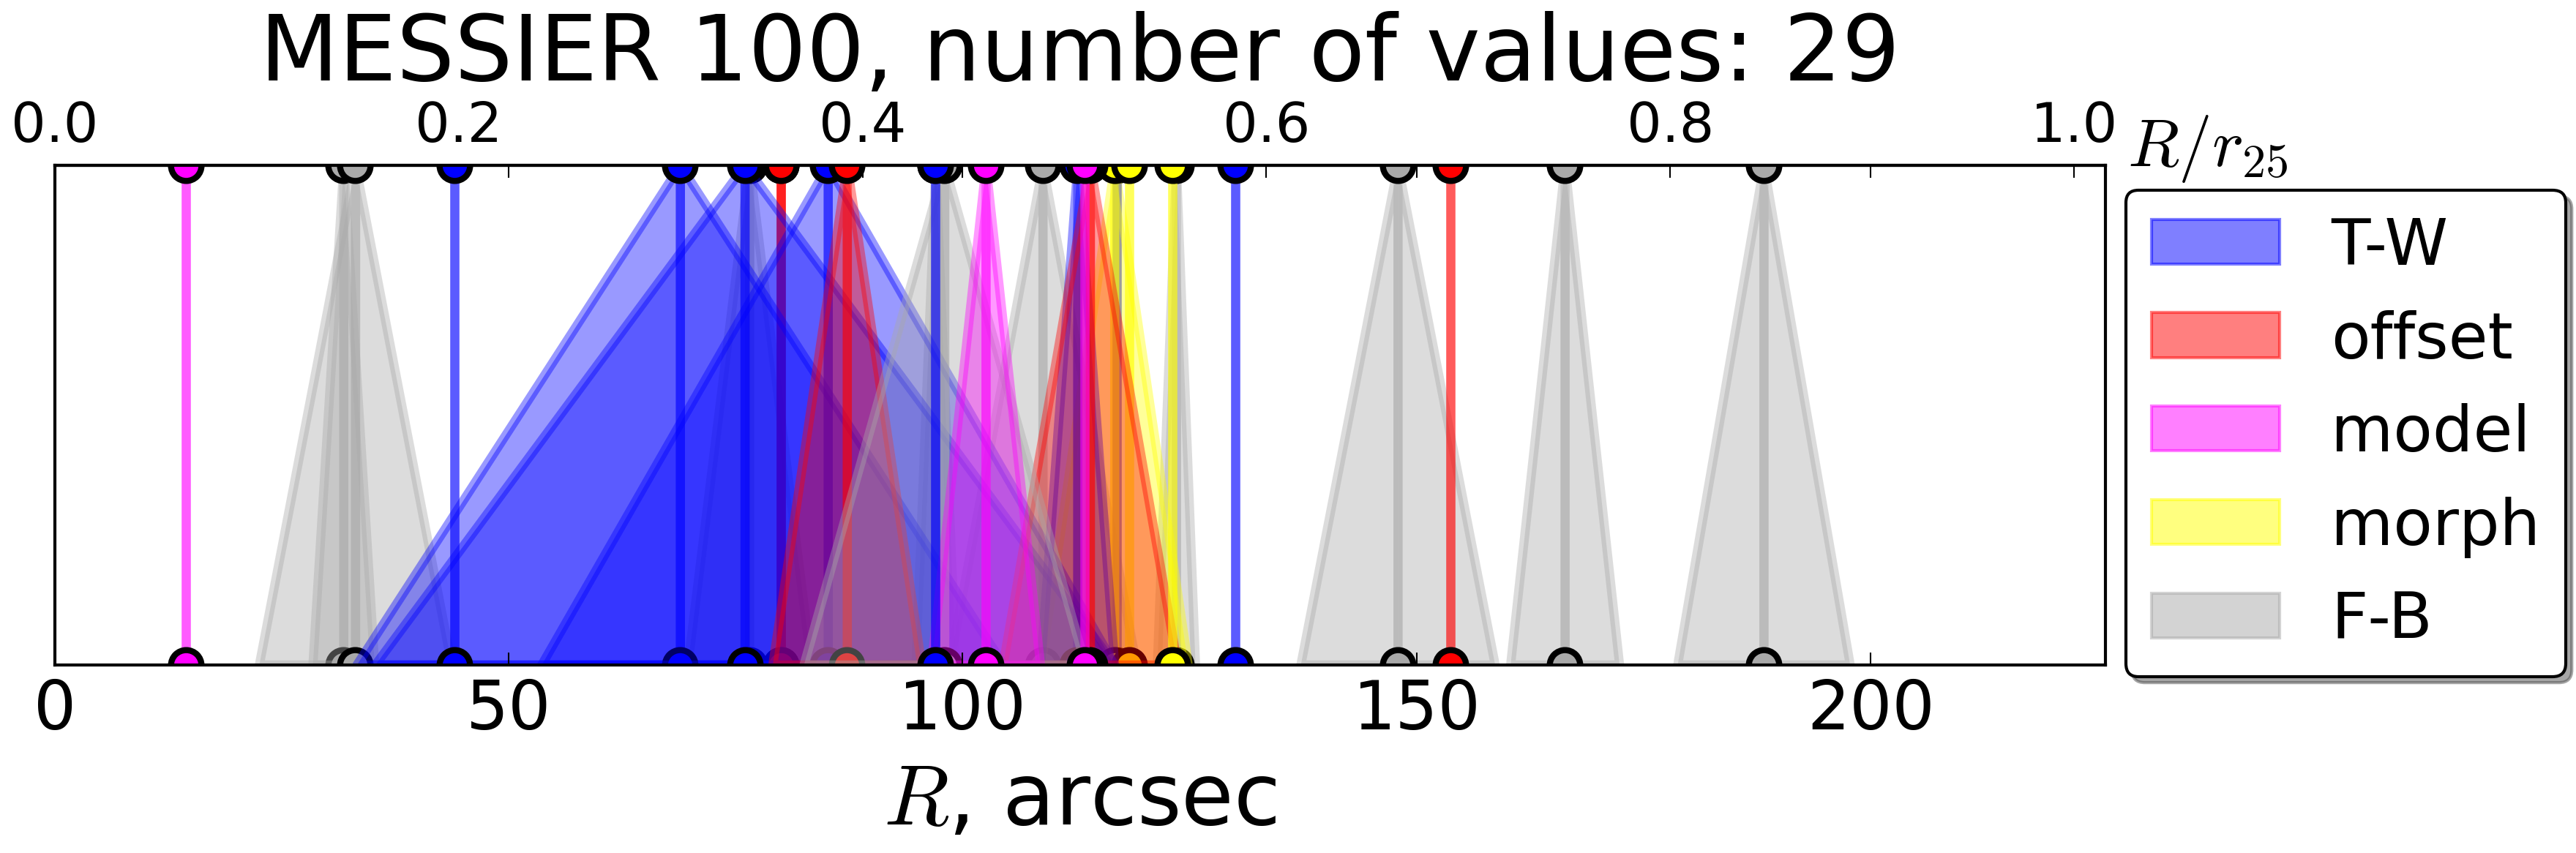

In [4]:
Image('./../CR_distributions/MESSIER 100.png', width=800)

### F-B method

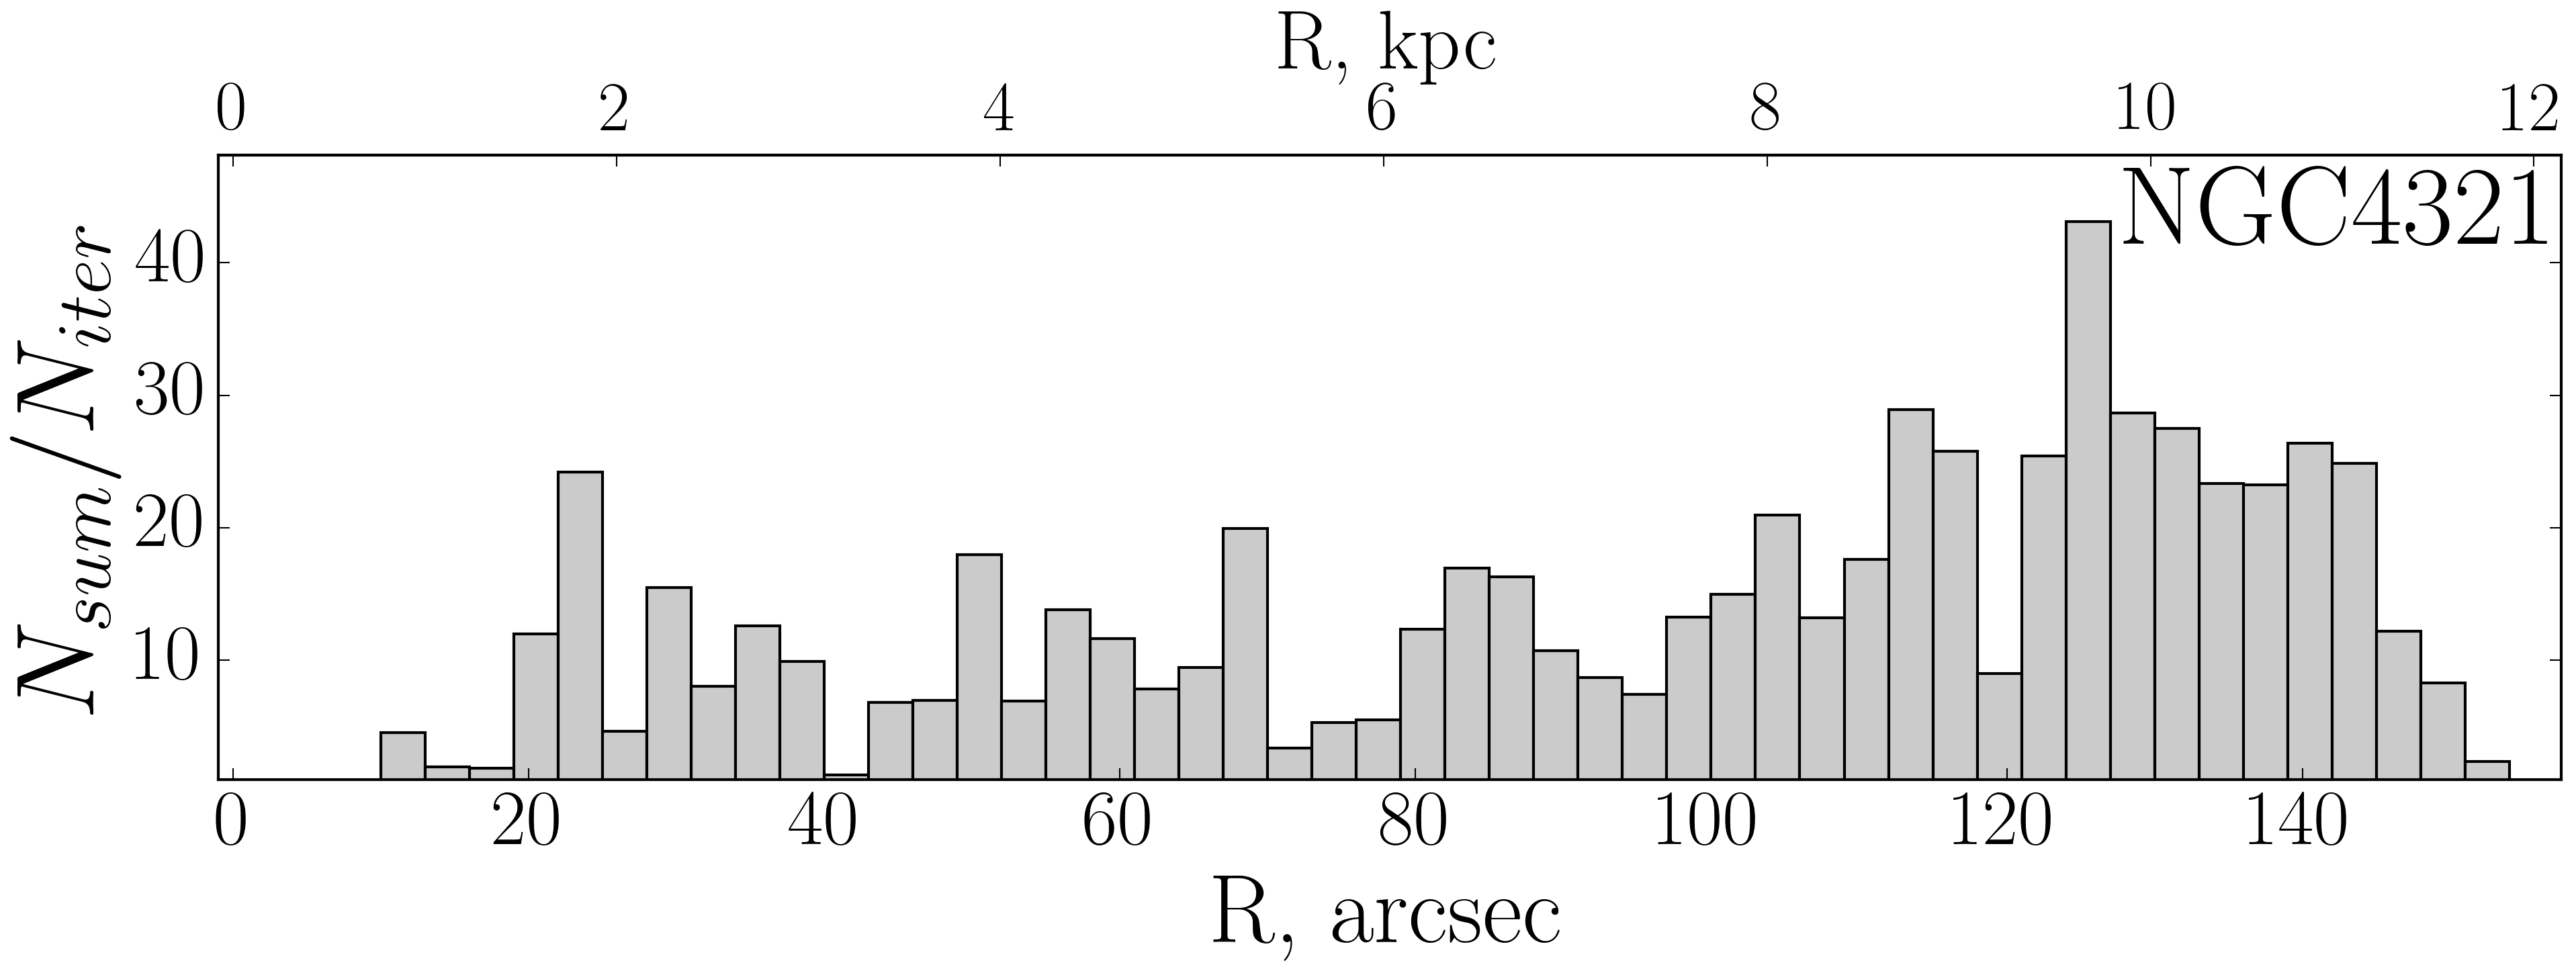

In [5]:
Image('./../methods/F-B method/results_images/NGC4321_F-B.png', width=800)

### consistency

In [3]:
df = pd.read_csv('./../data/total_crs.csv',index_col=0) 
method_color = {'F-B' : '#354247',
 'F-B (this work)' : '#354247',               
 'P-D' : 'darkslategrey',
 'P-D(bar)' : 'darkslategrey',
 'SNs' : 'lightsalmon',
 'T-W' : 'blue',
 'T-W(bar)' : 'blue',
 'bar-torque' : 'limegreen',
 'gaps(bar)' : 'thistle',
 'gaps' : 'thistle',
 'metallicity' : '#5e7015',               
 'model' : 'magenta',
 'model(bar)' : 'magenta',
 'morph' : 'yellow',                         
 'offset' : 'red',
 'offset (this work)' : 'red',
 'potential-density' : 'cyan',
 'rings(bar)' : 'sienna',
 'rings' : 'sienna',
 'widths' : 'goldenrod',
 'metallicity (Bresolin, 2022)' : '#599e64', 
 'metallicity (McCall, 1982)' : '#1d8427',
 'metallicity (Berg, 2013)' : '#add243',
 'consistent': '#2765a3' }

In [13]:
def assymGauss(x, a, x0, s11, s12):
    test = x<=x0
    P = np.where(test, a*np.exp(-((x-x0)/s11)**2), a*np.exp(-((x-x0)/s12)**2))
    return P

def DoubleGauss(x, a1, x01, s11, s12, a2, x02, s21, s22):
    return assymGauss(x, a1, x01, s11, s12) + assymGauss(x, a2, x02, s21, s22)

def TripleGauss(x, a1, x01, s11, s12, a2, x02, s21, s22, a3, x03, s31, s32):
    return assymGauss(x, a1, x01, s11, s12) + assymGauss(x, a2, x02, s21, s22) + assymGauss(x, a3, x03,  s31, s32)

def QuadrupleGauss(x, a1, x01, s11, s12, a2, x02, s21, s22, a3, x03, s31, s32, a4, x04, s41, s42):
    return assymGauss(x, a1, x01, s11, s12) + assymGauss(x, a2, x02, s21, s22) + assymGauss(x, a3, x03,  s31, s32) + assymGauss(x, a4, x04, s41, s42)

def FitGauss(X,Y,num_Gauss=None,init_approx=None,bounds=None):
    
    if num_Gauss==1:
        p, cov = curve_fit(assymGauss, X, Y, p0=init_approx, bounds=bounds)

    elif num_Gauss==2:
        p, cov = curve_fit(DoubleGauss, X, Y, p0=init_approx, bounds=bounds)
        
    elif num_Gauss==3:
        p, cov = curve_fit(TripleGauss, X, Y, p0=init_approx, bounds=bounds)
        
    elif num_Gauss==4:
        p, cov = curve_fit(QuadrupleGauss, X, Y, p0=init_approx, bounds=bounds)
        
    return p 
def find_reliable_cr(gal_name, add_measure=None, del_measure=None, r_max=None, peak_num=None, cr0=None, show_fit=False, min_err=None, get_params=False, get_curve=False):
    
    altname = Ned.query_object(gal_name)['Object Name']
    cr = []
    cr_r = []
    cr_l = []
    for ind, row in df[df['altname']==altname[0]].iterrows(): 
        if del_measure is not None:
            if row['paper_name'] in del_measure:
                continue
            else:
                cr.append(row['cr']) 
                if row['err_cr_r']>0:
                    crr=row['err_cr_r']
                else:
                    crr=min_err
                if row['err_cr_l']>0:
                    crl=row['err_cr_l']
                else:
                    crl=min_err    
                cr_r.append(crr)
                cr_l.append(crl)
        else:        
            cr.append(row['cr']) 
            if row['err_cr_r']>0:
                crr=row['err_cr_r']
            else:
                crr=min_err
            if row['err_cr_l']>0:
                crl=row['err_cr_l']
            else:
                crl=min_err    
            cr_r.append(crr)
            cr_l.append(crl)
    
    if add_measure is not None:
        for measure in add_measure:
            cr.append(measure[0]) 
            cr_r.append(measure[2])
            cr_l.append(measure[1])

    points = np.linspace(0,r_max,1000)
    F_Gauss = np.zeros(1000)
    for ind in range(len(cr)):
        F_Gauss = F_Gauss + assymGauss(points,1,cr[ind],cr_l[ind],cr_r[ind])
    
    init_approx = []
    bounds_l = []
    bounds_r = []
    for i in range(peak_num):
        init_approx += [1,cr0[i],30,30]
        bounds_l += [1,cr0[i]-30,5,5]
        bounds_r += [8,cr0[i]+30,100,100] 
        
    params = FitGauss(points,F_Gauss,num_Gauss=peak_num,init_approx=init_approx, bounds=[bounds_l,bounds_r])
    crs = np.array(params).reshape((peak_num,4))
    print(crs)
    if get_params:
        return crs
    if show_fit:
        fig = plt.figure(figsize=[15,4])
        plt.subplots_adjust(wspace=0.05, hspace=0.1)
        gs = GridSpec(1, 6, figure=fig) 
        ax = fig.add_subplot(gs[0, 0:])
        ax.plot(points,F_Gauss,'--',linewidth=5,color='#5886a5')
        fit_gauss =  assymGauss(points,*params)
        ax.plot(points,fit_gauss,'-',linewidth=3,color='#bd4f4f')
        
    if get_curve:
        fit_gauss =  assymGauss(points,*params)
        return points, fit_gauss

[[ 5.47461506 97.41797347 50.89201568 45.23715366]]


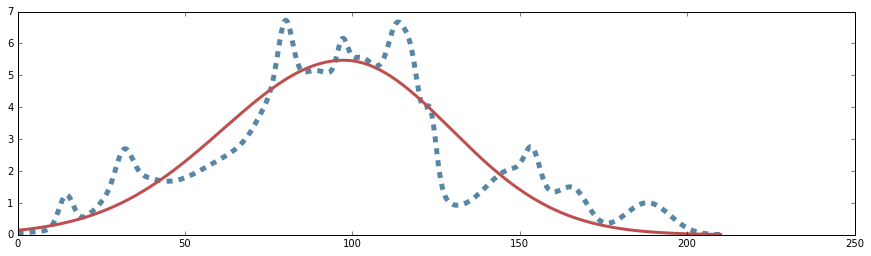

In [14]:
find_reliable_cr('NGC4321',add_measure=None,del_measure=None,r_max=210,peak_num=1,cr0=[100],show_fit=True,min_err=3)

In [29]:
def plot_cr_colorlegend(gal_name=None, ax=None, loc=None, fontsize=None, used_methods=None, bars=None):
    if used_methods is None:
        methods = []
        for ind, row in df.iterrows():
            methods.append(row['method'])
        methods = set(methods)
    else:
        methods = set(used_methods)
                
    patches = []
    
    for ind,method in enumerate(methods):
        patch = mpatches.Patch(color=method_color[method], label=method, alpha=0.5)
        patches.append(patch)
    if fontsize is None:
        ax.legend(handles=patches, loc=loc)
        ax.legend(handles=patches, bbox_to_anchor=(1.01,1.2), loc="upper left", 
          fancybox=True, shadow=True, ncol=1)
    else:
        ax.legend(handles=patches, loc="lower right")
        ax.legend(handles=patches, bbox_to_anchor=(1.01,0.96), loc="upper left", fontsize=fontsize,
          fancybox=True, shadow=True, ncol=1, borderaxespad=0.)
        
def plot_crs(gal_name, add_measure=None, del_measure=None,axx=None,legend=True,verbose=False,mode='box',r25=None,
                                             plot_gauss=False,peak_num=None, cr0=None,r_max=None,min_err=None):
    
    if axx is None:
        fig = plt.figure(figsize=[12,2.8])
        ax = plt.gca()
    else:
        ax = axx
        
    ylim = 0
    xlim = 0
    
    ylim_ = 1e10
    xlim_ = 1e10
    
    mets = []
    cc = 0 
    
    altname = Ned.query_object(gal_name)['Object Name']
    cr = []
    cr_r = []
    cr_l = []
    bars = []
    for ind, row in df[df['altname']==altname[0]].iterrows(): 
        if del_measure is not None:
            if row['paper_name'] in del_measure:
                continue
            else:
                cr.append(row['cr']) 
                cr_r.append(row['err_cr_r'])
                cr_l.append(row['err_cr_l'])
                mets.append(row['method']) 
                bars.append(row['bar'])
        else:        
            cr.append(row['cr']) 
            cr_r.append(row['err_cr_r'])
            cr_l.append(row['err_cr_l'])
            mets.append(row['method']) 
            bars.append(row['bar'])
    
    if add_measure is not None:
        for measure in add_measure:
            cr.append(measure[0]) 
            cr_r.append(measure[2])
            cr_l.append(measure[1])
            mets.append(measure[3])
            bars.append('False')
            
    for ind in range(len(cr)):
    
        if verbose:
            print(info, mets[ind])

        if mets[ind] == 'SNs':
            ax.scatter(cr[ind], 50, 100, color=method_color[mets[ind]], label=mets[ind])
        else:
            if mode == 'box':
                ax.axvspan(cr[ind]-abs(cr_l[ind]), cr[ind]+cr_r[ind], alpha=0.5, color=method_color[mets[ind]], label=mets[ind],linewidth = 1)
            else:
                ax.fill_between([cr[ind]-abs(cr_l[ind]), cr[ind]], [0, 100.], alpha=0.4, color=method_color[mets[ind]], label=mets[ind],linewidth=3)
                ax.fill_between([cr[ind],  cr[ind]+cr_r[ind]], [100, 0.], alpha=0.4, color=method_color[mets[ind]], label=mets[ind],linewidth=3)   
            
            ax.scatter(cr[ind], 0, 100, color=method_color[mets[ind]], alpha=1, edgecolor='k',linewidth = 2)
            ax.scatter(cr[ind], 100, 100, color=method_color[mets[ind]], alpha=1, edgecolor='k',linewidth = 2)
            cc+=1
    if verbose:
            print('===='*30)
    if len(cr)==0:
        if verbose:
            print(f'Gal {gal_name} not in entry {ind} ({row["method"]} / {row["link"]}), continue...')
            
    if legend:
        plot_cr_colorlegend(gal_name, ax, loc='lower right', fontsize=18, used_methods=mets)   
    
    if verbose:
           print(f'Gal {gal_name} IN entry {ind} ({row["method"]} / {row["link"]}):')        
    
    # ax.set_title(altname[0]+', number of values: '+str(len(cr_)), fontsize=30,pad=28)
    if axx is None:
        ax.set_xlabel(r'$R$, arcsec', fontsize=28)
        ax.tick_params(axis='both', which='major', labelsize=22,labeltop=False,top=False)  
    else:  
        ax.tick_params(axis='both', which='major', labelsize=22,labeltop=False,top=False,labelbottom=False)  
    ax.set_yticks([])
    ax.set_facecolor('white')
        
    ax.set_ylim(0, 100)
    ax.set_xlim(0, r_max)
    ax.tick_params(axis='both', which='major', labelsize=22,labeltop=False,top=False)  
    
    if plot_gauss:
        points, fit_gauss = find_reliable_cr(gal_name,add_measure=add_measure,del_measure=del_measure,r_max=r_max,
                                             peak_num=peak_num,cr0=cr0,min_err=min_err,get_curve=True)
        ax.axhline(y=100, color='k',linewidth=2)
        ax.plot(points, fit_gauss*10+101, '-', color='#2765a3',linewidth=2)
        ax.set_ylim(0, 135)
        
    if r25 is not None:
        
        def to_new_axis(x):
            return x/r25
        
        def from_new_axis(x):
            return x*r25
        
        secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        secax.tick_params(axis='both', which='major', labelsize=18)
        # secax.set_xlabel(r'$R/r_{25}$', fontsize=22)
        # secax.xaxis.set_label_coords(1.05, 2)

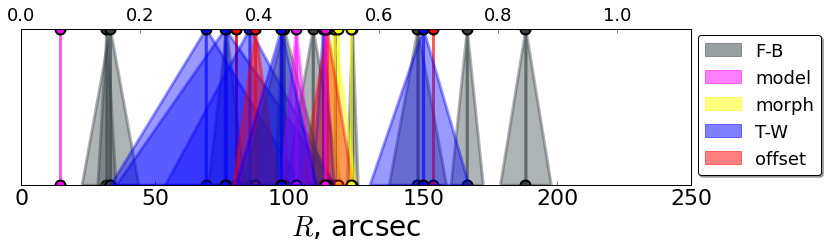

In [33]:
altname = Ned.query_object('NGC4321')['Object Name'][0]
r25_ = []
for ind, row in df[df['altname']==altname].iterrows():
    r25_.append(row['r25_NED'])
plot_crs('NGC4321', add_measure=None, del_measure=None,axx=None,legend=True,verbose=False,mode=None,r25=min(r25_),
         plot_gauss=None,peak_num=None, cr0=None,r_max=250,min_err=None)
# plt.text(2,109,r'$R_c = 36^{+8}_{-5}$ "', fontsize=32)
plt.savefig('./NGC4321/NGC4321_distr.jpg',transparent = False, dpi=250, bbox_inches='tight', pad_inches=0.05, facecolor='white')

### metallicity gradient method

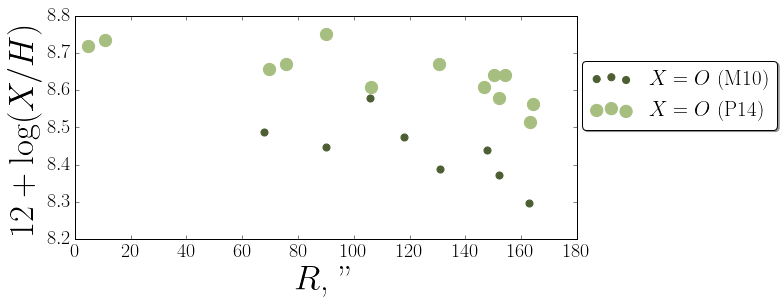

In [7]:
## data taken from Pilyugin (2014) and Moustakas (2010)
metallicity = pd.read_csv('./NGC4321/NGC4321_metal.csv',index_col=None) 
metallicity = metallicity.drop(index=0)

R_25M = 3.71*60
R_25P = 3.71*60

M_OH_r = [float(val)*R_25M  for val in metallicity['Moustakas_O/H'].values if float(val)>=0]
M_OH_z = [float(val)  for val in metallicity['Unnamed: 1'].values if float(val)<10]

P_OH_r = [float(val)*R_25M  for val in metallicity['Pilyugin_O/H'].values if float(val)>=0]
P_OH_z = [float(val)  for val in metallicity['Unnamed: 3'].values if float(val)<10]

P_NH_r = [float(val)*R_25M  for val in metallicity['Pilyugin_N/H'].values if float(val)>=0]
P_NH_z = [float(val)  for val in metallicity['Unnamed: 5'].values if float(val)<10]


scale_Z = np.pi / (180 * 3600) * 17.2 * 10**3
metallicity = np.loadtxt('./NGC4321/metal_Zurita20.dat') 
Z_r = metallicity[:,0]/scale_Z
Z_z = metallicity[:,1]

# McCall_OH_r = [float(val)  for val in metallicity[:,0]]
# McCall_OH_z = [float(val)-0.5  for val in metallicity[:,1]]
# S_OH_r = [float(val)  for val in metallicity[:,2]]
# S_OH_z = [float(val)-0.5  for val in metallicity[:,3]]

fig = plt.figure(figsize=[9,4])

plt.scatter(M_OH_r,M_OH_z,[50],marker='o',color='#4d5e33', label=r'$X=O$ (M10)') 
plt.scatter(P_OH_r,P_OH_z,[150],marker='o',color='#a6be7f', label=r'$X=O$ (P14)') 

# plt.scatter(Z_r,Z_z,[50],marker='^',color='#4d5e33', label=r'$X=O$ (Z20)') 
# plt.scatter(P_NH_r,P_NH_z,[150],marker='<',color='#a6be7f', label=r'$X=N$ (P14)')
plt.xlabel(r'$R$, "', fontsize=35)            

plt.tick_params(axis='both', which='major', labelsize=20)  
#plt.text(xlim+30, 0.1, r'metallicity', fontsize=25, va='top')
plt.ylabel(r'$12 + \log(X/H)$', fontsize=35)
plt.xlim(0,180)
plt.ylim(8.2,)
plt.legend(bbox_to_anchor=(1.01,0.8), loc="upper left", fontsize=21,
         fancybox=True, shadow=True, ncol=1, borderaxespad=0.)

In [16]:
# azimuthally averaged map of metallicity distribution
def angles(V1,U1,V2,U2,V3,U3):
    c = (V3-V1)**2 + (U3-U1)**2
    a = (V2-V1)**2 + (U2-U1)**2
    b = (V3-V2)**2 + (U3-U2)**2
    
    cos = (c-a-b)  / 2. / np.sqrt(a) / np.sqrt(b)
    return np.arccos(cos)

def get_phi_array(x_cen,y_cen,PA,size):
    
    vec = x_cen - y_cen * np.tan(PA*np.pi/180.)
    
    phi = np.zeros((size[0],size[1]))
    for j in range(len(phi[0])):
        for i in range(len(phi)):
            phi[i][j] = angles(j,i,x_cen ,y_cen,vec,0.)*180./np.pi

    return phi

data = fits.getdata("./NGC4321/NGC4321_metallicity.fits")
data_WCS =  WCS("./NGC4321/NGC4321_metallicity.fits", naxis = 2)
data_metal = np.squeeze(data)

PA = 24
RA = Ned.query_object('NGC4321')['RA']
DEC = Ned.query_object('NGC4321')['DEC']
cposition = SkyCoord('{} {}'.format(RA[0],DEC[0]), frame='icrs', unit='deg', equinox='J2000.0')
cpixel = skycoord_to_pixel(cposition,data_WCS)
phi = get_phi_array(cpixel[0],cpixel[1],PA,data_metal.shape)
cosi = np.cos(34.*np.pi/180.)

In [12]:
dist = []
Z = []
data_metal = np.nan_to_num(data_metal)


for j in range(0,len(data_metal[0]),5):
        for i in range(0,len(data_metal),5): 
            
            if data_metal[i][j] != 0:
            
            
                position = pixel_to_skycoord(i,j,data_WCS)
                R = cposition.separation(position)
                R_depr = np.sqrt((R.arcsec*np.sin(phi[i][j]/180.*np.pi)/cosi)**2 + (R.arcsec*np.cos(phi[i][j]/180.*np.pi))**2)
                dist.append(R_depr)
                Z.append(data_metal[i,j])
                
R_mean = []
Z_mean = []
Z_disp = []
R_arcsec = np.linspace(0,max(dist),20)
for ind,r_l in enumerate(R_arcsec[0:-1]):
    R=[]
    z=[]
    for i,r in enumerate(dist):
        
        if r_l<r<R_arcsec[ind+1]:
            R.append(r)
            z.append(Z[i])

    R_mean.append(np.mean(np.array(R)))
    Z_mean.append(np.median(z))
    Z_disp.append(np.std(z))                

(0.0, 200.0)

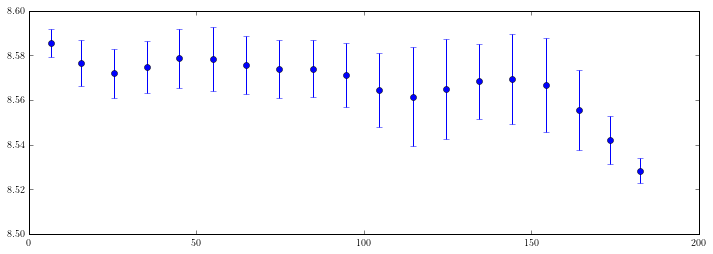

In [13]:
fig, ax0 = plt.subplots(ncols=1, sharey=True, figsize=(12, 4))

ax0.errorbar(R_mean,Z_mean, yerr=Z_disp, linestyle='',marker='o')
ax0.set_ylim(8.5,8.6)
ax0.set_xlim(0,200)


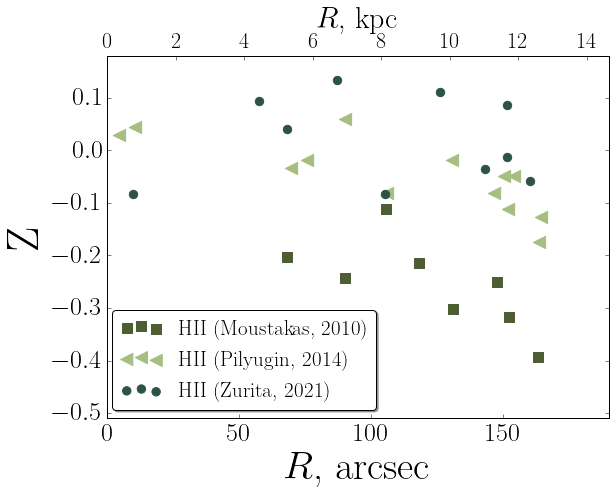

In [12]:
fig, ax = plt.subplots(figsize=[9,6.5])
solar_metal = 8.69

plt.scatter(M_OH_r,np.array(M_OH_z)-solar_metal,[100],marker='s',color='#4d5e33', label=r'HII (Moustakas, 2010)') 
plt.scatter(P_OH_r,np.array(P_OH_z)-solar_metal,[150],marker='<',color='#a6be7f', label=r'HII (Pilyugin, 2014)') 

# plt.scatter(McCall_OH_r,np.array(McCall_OH_z)-solar_metal,[80],marker='o',color='#4d5e33', label=r'HII (McCall, 1985)') 
# plt.scatter(S_OH_r,np.array(S_OH_z)-solar_metal,[100],marker='+',color='#a6be7f', label=r'HII (Shields, 1991)') 
# plt.scatter(P_NH_r,P_NH_z,[150],marker='<',color='#a6be7f', label=r'$X=N$ (P14)')

# plt.scatter(R_mean,np.array(Z_mean)-solar_metal,[70],color='#2c5445', label=r'Azim.avarage map (Williams, 2022)')
plt.scatter(Z_r,Z_z-solar_metal,[70],color='#2c5445', label=r'HII (Zurita, 2021)')
#plt.errorbar(R_mean,Z_mean, yerr=Z_disp, linestyle='', color = '#4c8b74')
plt.xlabel(r'$R$, arcsec', fontsize=40)            

plt.tick_params(axis='both', which='major', labelsize=26,top=False)  
#plt.text(xlim+30, 0.1, r'metallicity', fontsize=25, va='top')
plt.ylabel(r'$\rm Z$', fontsize=45)
plt.xlim(0,190)
plt.ylim(-0.51,0.18)
plt.legend(bbox_to_anchor=(0.01,0.3), loc="upper left", fontsize=21,
         fancybox=True, shadow=True, ncol=1, borderaxespad=0.)

def to_new_axis(x):
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    return x*scale

def from_new_axis(x):
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    return x/scale

secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
secax.tick_params(axis='both', which='major', labelsize=22)
secax.set_xlabel(r'$R$, kpc', fontsize=30)

plt.savefig('./NGC4321/NGC4321_metal.png',transparent = False, dpi=200, bbox_inches='tight', pad_inches=0.05)

### PanSTARRS image

/tmp/ipykernel_5085/2766756611.py:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  pcm.cmap.set_over('white')


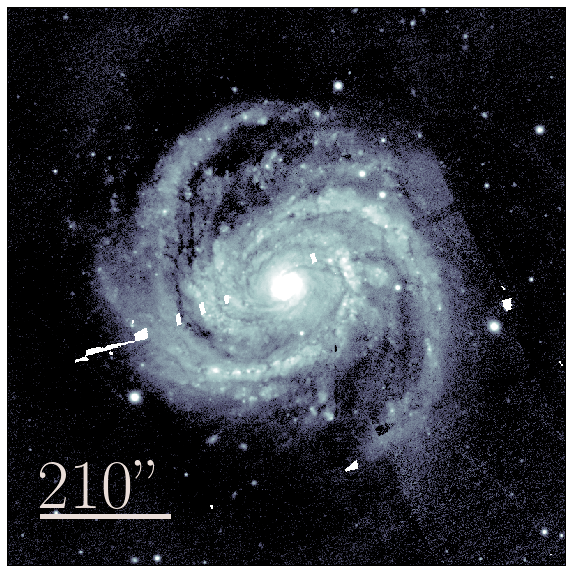

In [26]:
data_g = fits.getdata('./NGC4321/PanSTARRS_g.fits')
data_r = fits.getdata('./NGC4321/PanSTARRS_r.fits')
data_i = fits.getdata('./NGC4321/PanSTARRS_i.fits')
data_z = fits.getdata('./NGC4321/PanSTARRS_z.fits')

data_g = np.where(data_g<0,0.1,data_g)
data_r = np.where(data_r<0,0.1,data_r)
data_i = np.where(data_i<0,0.1,data_i)
data_z = np.where(data_z<0,0.1,data_z)

X,Y = np.meshgrid(np.arange(0,data_g.shape[1], 1), np.arange(0,data_g.shape[0], 1))
fig = plt.figure(figsize=[10,10])
pcm = plt.pcolormesh(X, Y, np.log10(data_g+data_z+data_i+data_r), cmap = "bone")
pcm.set_clim(vmin=1,vmax=3.5)
pcm.cmap.set_over('white')
# plt.colorbar()
plt.xlim(50,data_g.shape[1]-50)
plt.ylim(50,data_g.shape[1]-50)
plt.plot([100,280],[120,120],linewidth=5,color='#e9ddd8')
plt.text(95,130,'210"',fontsize=70,weight="bold",color='#e9ddd8')
plt.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False,right=False,labelright=False,top=False,labeltop=False)
plt.savefig('./NGC4321/NGC4321_PanSTARRS.jpg',transparent = False, dpi=250, bbox_inches='tight', pad_inches=0.05, facecolor='white')

### Spirals traced by different stellar population

In [ ]:
### fits-files are from https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..25N/abstract
### These images were initially deprojected and transferred into polar coordinate system.

In [4]:
import zoomdown

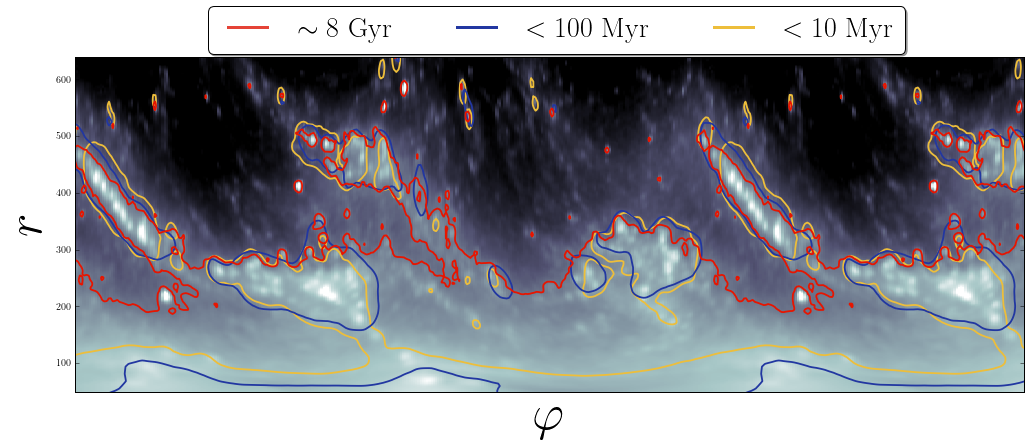

In [17]:
# data_ion = fits.getdata("./NGC4321/stars_ionizing_to_polar.fits")
# Data_ion = np.squeeze(data_ion)
# data_ion_zoom = zoomdown.zoomdown(Data_ion,0.8)

# x_vals = np.linspace(0, int(720*0.8), int(720*0.8))
# y_vals = np.linspace(0, int(800*0.8), int(400*0.8))

# X_ion, Y_ion = np.meshgrid(x_vals, y_vals) 

# data_old = fits.getdata("./NGC4321/stars_old_to_polar.fits")
# Data_old = np.squeeze(data_old)
# data_old_zoom = zoomdown.zoomdown(Data_old,0.8)

# data_young = fits.getdata("./NGC4321/stars_young_to_polar.fits")
# Data_young = np.squeeze(data_young)
# data_young_zoom = zoomdown.zoomdown(Data_young,0.8)

# x_vals = np.linspace(0, int(720*0.8), int(720*0.8))
# y_vals = np.linspace(0, int(800*0.8), int(188*0.8)+1)
# X_young, Y_young = np.meshgrid(x_vals, y_vals) 

plt.figure(figsize=[17, 6])
CS = plt.contour(X_ion,Y_ion,np.log10(data_ion_zoom.data), levels=[-4.15],  alpha=1,linewidths=1.8, colors=['#edbe3b','#a6fb7b'])
CS = plt.contour(X_young,Y_young,np.log10(data_young_zoom.data), levels=[-3.45],  alpha=1,linewidths=1.8, colors=['#2237a1','#83d5ed'])
CS = plt.contour(np.log10(data_old_zoom.data), levels=[-4.87],  alpha=1,linewidths=1.8, colors=['#e71500','#f47638','#ffd8ca'])
quadmesh = plt.pcolormesh(np.log10(data_old_zoom.data), cmap='bone')
# quadmesh = plt.pcolormesh(X_young,Y_young,np.log10(data_young_zoom.data), cmap='gist_yarg')
quadmesh.set_clim( vmin=-5.4, vmax=-4.3)

plt.axhline(-20,linewidth=3, color='#e54337', label= r'$ \sim 8$ Gyr')
plt.axhline(-20,linewidth=3, color='#2237a1', label= r'$ < 100$ Myr')
plt.axhline(-20,linewidth=3, color='#edbe3b', label= r'$ < 10$ Myr')

plt.xlim(120,550)
plt.ylim(50,)

plt.xlabel(r'$\varphi$',fontsize=50)
plt.ylabel(r'$r$',fontsize=50)
plt.legend(bbox_to_anchor=(0.14,1.15), loc="upper left", fontsize=28,
         fancybox=True, shadow=True, ncol=3, borderaxespad=0.)
# plt.yticks([])
plt.xticks([])

plt.savefig('./NGC4321/NGC4321_age_gradient.png',transparent = False, dpi=150, bbox_inches='tight', pad_inches=0.05)

### Surface brightness profile

In [5]:
Distance = Mpc
cosi=np.cos(35 / 180. * np.pi)

In [6]:
def cut_fits(first_fits=None, second_fits=None, size=None,galname=None):
    RA = Ned.query_object(galname)['RA']
    DEC = Ned.query_object(galname)['DEC']
    cposition = SkyCoord('{} {}'.format(RA[0],DEC[0]),  frame='icrs', unit='deg')
    
    first_data = fits.getdata(first_fits)
    first_data = np.squeeze(first_data)
    first_WCS = WCS(first_fits, naxis = 2) 
        
    second_data = fits.getdata(second_fits)
    second_data = np.squeeze(second_data)
    second_WCS = WCS(second_fits, naxis = 2)
    
    size = u.Quantity(size, u.arcsec)
    
    first_data = Cutout2D(first_data, cposition, size, wcs=first_WCS, mode='partial', fill_value=0.)
    second_data = Cutout2D(second_data, cposition, size, wcs=second_WCS, mode='partial', fill_value=0.)
    
    return first_data, second_data  

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

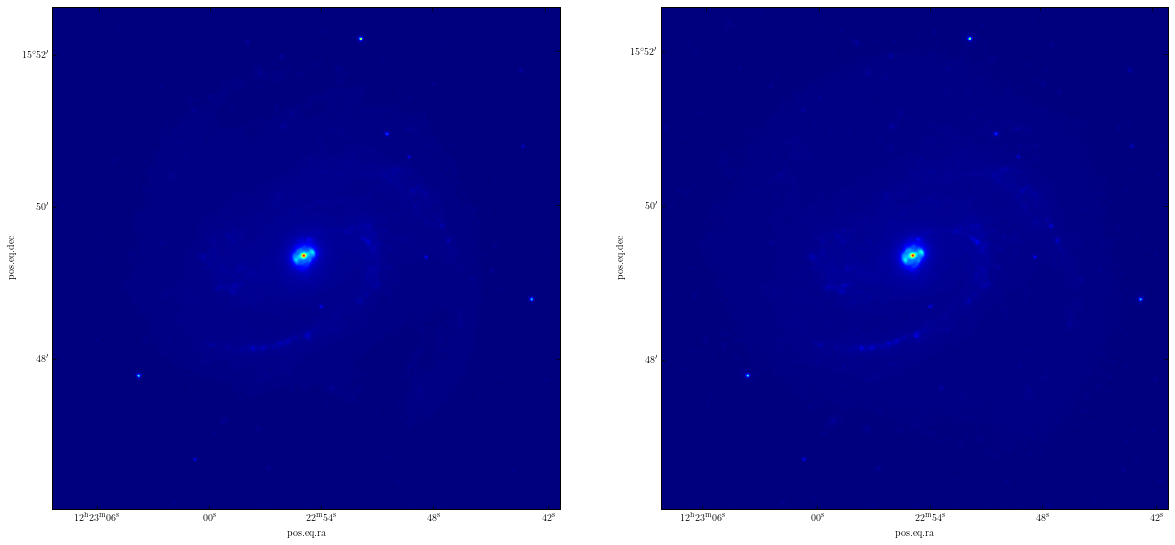

(533, 533)
(533, 533)


In [9]:
size=[400,400]
I_36, I_45 = cut_fits(first_fits = './NGC4321/NGC4321_3.6.fits', second_fits ='./NGC4321/NGC4321_4.5.fits', size = size, galname='NGC4321') 
fig = plt.figure(figsize=[20, 9])
ax = fig.add_subplot(121, projection=I_36.wcs)

ax.imshow(I_36.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=I_45.wcs)
ax2.imshow(I_45.data, origin='lower', aspect="auto")

plt.show()

print(I_36.shape)
print(I_45.shape)  

In [10]:
I_36_Jy= np.array(I_36.data).reshape(I_36.shape)
I_45_Jy= np.array(I_45.data).reshape(I_45.shape)
# from MJy/ster to Jy
F_36 = I_36_Jy * 10**6 * (0.75 * np.pi / 180 / 3600)**2
F_45 = I_45_Jy * 10**6 * (0.75 * np.pi / 180 / 3600)**2

M_star = np.power(10,8.35,dtype = float) * np.power(F_36,1.85,dtype = float) * np.power(F_45,-0.85,dtype = float) * Distance**2 *cosi
pc_arcsec = (Distance*10**6*2*np.pi)/(360*60*60.)
arcsec_pix = 0.75
pixel_size = pc_arcsec * arcsec_pix
Sigma_s = M_star/pixel_size**2

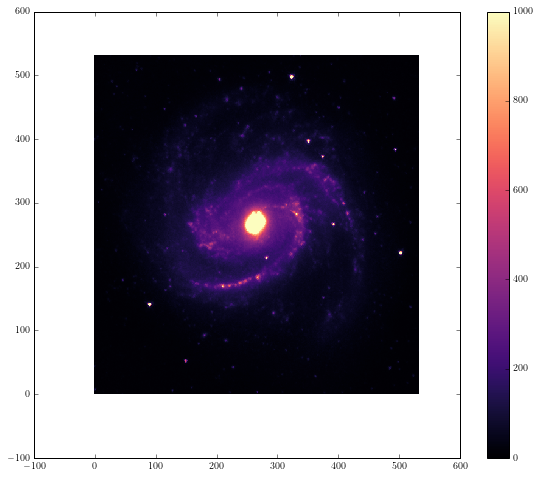

In [11]:
fig = plt.figure(figsize = [21,8])
ax1 = fig.add_subplot(121)
X, Y = np.meshgrid(np.arange(0,533,1), np.arange(0,533,1))
quadmesh = plt.pcolormesh(X, Y,Sigma_s, cmap='magma')
quadmesh.set_clim(vmin=0., vmax=1000.)
plt.colorbar()

In [12]:
# data = I_36_header.copy()
fits.PrimaryHDU(data=Sigma_s).writeto('./NGC4321/Sigma_s.fits', overwrite=True)

In [13]:
def get_profile(galname,fits_file=None,incl=None,PA=None,dist_max=None):
    
#     RA = Ned.query_object(galname)['RA']
#     DEC = Ned.query_object(galname)['DEC']
#     cposition = SkyCoord('{} {}'.format(RA[0],DEC[0]), frame='fk5', unit='deg', equinox='J2000.0')
#     data =  WCS(fits_file, naxis = 2)
#     x0,y0 = skycoord_to_pixel(cposition,data)
    
#     shiftdeg = pixel_to_skycoord(x0-1.,y0,data)
#     resol = abs(shiftdeg.ra.arcsec-cposition.ra.arcsec) #find pixel size
    cosi = np.cos(incl*np.pi/180.)
    PA = PA*np.pi/180.
    resol=0.75
    
    data = fits.getdata(fits_file)
    x0,y0 = data.shape[0]/2,data.shape[1]/2
    data = np.squeeze(data)
    
    data_dist = np.zeros(data.shape)
    data_bright = np.zeros(data.shape)

    
    X,Y = np.meshgrid(np.arange(0,data.shape[1], 1), np.arange(0,data.shape[0], 1))
    X_shift = X - x0
    Y_shift = Y - y0 
    X_rot = Y_shift * np.cos(PA) + X_shift * np.sin(PA)
    Y_rot0 =  -Y_shift * np.sin(PA) + X_shift * np.cos(PA)
    Y_rot = Y_rot0/cosi
    R = np.sqrt(X_rot**2 + Y_rot**2)*resol

    cut = (R<dist_max)

    data_bright = data[cut]
    data_dist = R[cut]

    return data_bright,data_dist

In [15]:
data_bright,data_dist = get_profile('NGC4321',fits_file='./NGC4321/Sigma_s.fits',incl=35,PA=84,dist_max=250)



/tmp/ipykernel_11289/2332857092.py:3: RuntimeWarning: invalid value encountered in divide
  hist_norm = hist.T/(2*np.pi*x_h[:-1])
/tmp/ipykernel_11289/2332857092.py:5: RuntimeWarning: divide by zero encountered in log10
  pcm = ax0.pcolormesh(x_h[:-1], y_h[:-1], np.log10(hist_norm),cmap = "inferno")
/tmp/ipykernel_11289/2332857092.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  pcm.cmap.set_bad('#21041f')


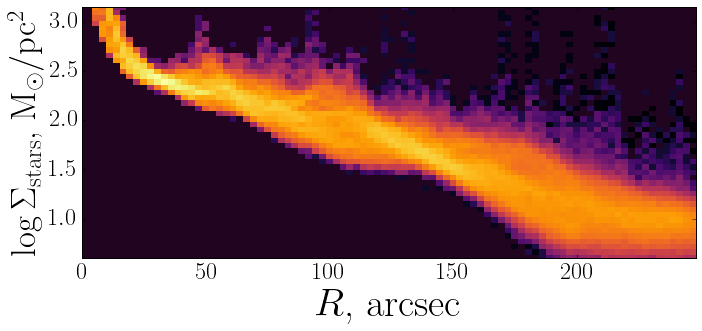

In [19]:
fig, ax0 = plt.subplots(ncols=1, sharey=True, figsize=(11, 4.5))
hist, x_h, y_h = np.histogram2d(data_dist,np.log10(data_bright),range=[[0,250],[0.5,3.2]],bins=[90,50])
hist_norm = hist.T/(2*np.pi*x_h[:-1])

pcm = ax0.pcolormesh(x_h[:-1], y_h[:-1], np.log10(hist_norm),cmap = "inferno")
pcm.cmap.set_bad('#21041f')
ax0.set_xlim(0,248)
ax0.set_ylim(0.6,3.15)
plt.xlabel(r'$R$, arcsec', fontsize=40)
plt.ylabel(r'$\log \Sigma_{\rm stars}$, $\rm M_\odot/ \rm pc^2$', fontsize=35)
plt.tick_params(axis='both', which='major',labelsize=24)
plt.savefig('./NGC4321/NGC4321_profile.jpg',transparent = False, dpi=150, bbox_inches='tight', pad_inches=0.05, facecolor='white')